# Baseline Model Development

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import statsmodels.api as sm


%matplotlib inline

In [120]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens')
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [121]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,first_year_elected,election_year,tenure,age,is_sponsor,sponsor_party_is_lead,cosponsor_party_D_%,cosponsor_party_R_%,percent_cosponsors_lead_party,sponsor_is_same_party
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1978,0,35,76,0,1,0.5,0.5,0.5,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1978,0,35,72,0,1,0.5,0.5,0.5,1
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1980,0,33,80,0,1,0.5,0.5,0.5,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1984,0,29,74,0,1,0.5,0.5,0.5,1
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1980,0,33,73,0,1,0.5,0.5,0.5,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110268 entries, 5 to 306260
Data columns (total 67 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       110268 non-null  int64  
 1   chamber                        110268 non-null  object 
 2   rollnumber                     110268 non-null  int64  
 3   icpsr                          110268 non-null  int64  
 4   cast_code                      110268 non-null  int64  
 5   state_abbrev                   110268 non-null  object 
 6   bioname                        110268 non-null  object 
 7   bioguide_id                    110268 non-null  object 
 8   born                           110268 non-null  int64  
 9   nominate_dim1                  110268 non-null  float64
 10  nominate_dim2                  110268 non-null  float64
 11  party                          110268 non-null  object 
 12  last_name                     

None

In [122]:
#drop any cast codes that are present or absent, and change cast code 6 ('nay') to 0
main_df.drop(main_df[~main_df['cast_code'].isin([1,6])].index, inplace=True)
main_df['cast_code'] = main_df['cast_code'].apply(lambda x: 0 if x == 6 else 1)

#drop anywhere df lacks sponsor info
main_df.dropna(subset=['sponsor'], inplace=True)

#dummy variable lead party designation
main_df['lead_party_D'] = main_df['lead_party'].apply(lambda x: 1 if x == 'D' else 0)

#exponentiate cosponsor values
for i in ['cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID']:
    main_df[i+'^2'] = main_df[i]**2
    
#dummy variable party and sponsor_party columns
for party in ['D', 'R']:
    main_df['party_'+party] = main_df['party'].apply(lambda x: 1 if x == party else 0)
    main_df['sponsor_party_'+party] = main_df['sponsor_party'].apply(lambda x: 1 if x == party else 0)

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,sponsor_is_same_party,lead_party_D,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,0,1,4.0,1,1,0,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,1,4.0,1,1,0,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,0,1,4.0,1,1,0,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,1,4.0,1,1,0,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,1,4.0,1,1,0,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100166 entries, 5 to 306260
Data columns (total 76 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       100166 non-null  int64  
 1   chamber                        100166 non-null  object 
 2   rollnumber                     100166 non-null  int64  
 3   icpsr                          100166 non-null  int64  
 4   cast_code                      100166 non-null  int64  
 5   state_abbrev                   100166 non-null  object 
 6   bioname                        100166 non-null  object 
 7   bioguide_id                    100166 non-null  object 
 8   born                           100166 non-null  int64  
 9   nominate_dim1                  100166 non-null  float64
 10  nominate_dim2                  100166 non-null  float64
 11  party                          100166 non-null  object 
 12  last_name                     

None

In [123]:
dep_col = 'cast_code'

senator_info = ['nominate_dim1', 'nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 
                'age', 'is_sponsor', 'sponsor_is_same_party', 'party_D', 'party_R']

bill_info = ['sponsor_party_is_lead', 'cosponsor_party_D_%', 'cosponsor_party_R_%', 
             'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R',
             'cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID',
             'cosponsors^2', 'cosponsors_D^2', 'cosponsors_R^2', 'cosponsors_ID^2']

indep_cols = senator_info + bill_info

In [144]:
scalar = StandardScaler()

In [145]:
y = main_df[dep_col]
X = main_df[indep_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# X_train_df = pd.DataFrame(X_train, columns=X.columns)
# X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [147]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values)

print(rfe.ranking_)

low_rank_features = []
for i in range(len(X.columns)):
    if rfe.ranking_[i] != 1:
        low_rank_features.append(X.columns[i])
        
print('Low ranked features: ', low_rank_features)

[1 1 1 1 3 4 6 1 1 5 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
Low ranked features:  ['tenure', 'age', 'is_sponsor', 'party_R', 'cosponsors_ID']


In [148]:
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.682614
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.037    
Dependent Variable: cast_code        AIC:              95774.3440
Date:               2020-05-26 09:18 BIC:              96003.2916
No. Observations:   70116            Log-Likelihood:   -47862.   
Df Model:           24               LL-Null:          -46136.   
Df Residuals:       70091            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
         Coef.     Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
x1       -0.1415     0.0235   -6.0110   0.0000    -0.1876   -0.0954
x2        0.0620     0.0085    7.3365   0.0000     0.0455 

In [149]:
cols_to_drop = ['is_sponsor', 'tenure', 'age', 'party_R', 'cosponsor_ID']
X = main_df[[x for x in indep_cols if x not in cols_to_drop]]
y = main_df[dep_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [150]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

[[  365 10607]
 [  704 18374]]
              precision    recall  f1-score   support

           0       0.34      0.03      0.06     10972
           1       0.63      0.96      0.76     19078

    accuracy                           0.62     30050
   macro avg       0.49      0.50      0.41     30050
weighted avg       0.53      0.62      0.51     30050

Accuracy score: 0.6236


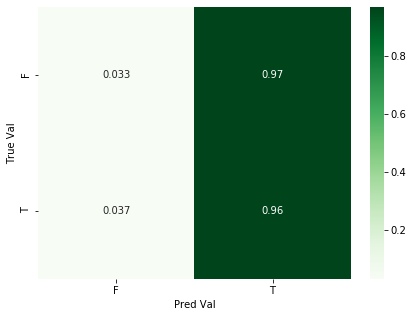

In [151]:
confusion_reporting(y_test, y_pred)

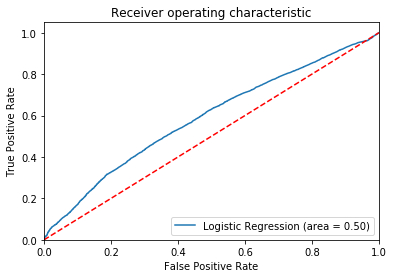

In [152]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()